# General Ensemble Models

The last few models we have studied have demonstrated that combining multiple models (like a *Random Forests* or *Boosting*) or otherwise building massive averaging to a model (like we did with *Neural Networks*) is a method capable of producing flexible models that are somewhat protected from overfitting. Models that are built by combining multiple models have the drawback of being harder to interpret.

In some applications, such as image recognition, interpretation is not the goal and we can easily give up interpretation in favor of models that perform better. In other applications, such as medical studies like models that are trying to predict cancer, interpretation is possibly needed because it would help inform future studies into the mechanisms and treatments of disease. On the other hand in some medical settings the goal is to build methods of automating treatment decisions and for these accuracy would be prefered over interpretation. In other applications such as studying housing data for a city intrepretation may be the primary reason for building a model. The example I keep in mind is my work on studying student success in mathematics and science courses, while it is interesting that neural networks produce very accurate predictions of which students need additional support, they are ineffective at being used for placement of students because we cannot answer the fundamental question of *What does the student need to do to improve their placement?*

## Why do Ensemble Models Work

Today we will look at a method of building ensemble models where the individual components are independently trained models. The key feature for ensemble models is that the individual components are trained on a bootstrapped or random sample of the training data. This introduces some randomness into the ensemble model and helps avoid a full model that has respond to the irreducible error.

The method we will look at today is called *Voting* (as usual there is a Classification and a Regression version of the idea). Consider the kidney disease data set.

In [34]:
import pandas as pa
import matplotlib.pyplot as plt
import matplotlib.colors as pltco
import numpy as np
import numpy.random as rn

In [57]:
kd = pa.read_csv('Data Sets/Kidney/chronic_kidney_disease.csv', 
                 names=['age', 'bp', 'specific_gravity', 'albumin', 'sugar', 'red_blood_cells', 'pus_cell',
                        'pus_cell_clumps', 'bacteria', 'blood_glucose', 'blood_urea', 'serum_creatinine', 
                        'sodium', 'potassium', 'hemoglobin', 'packed_cell_volume', 'white_blood_cell_count',
                        'red_blood_cell_count', 'hypertension', 'diabetes_mellitus', 'coronary_artery_disease',
                        'appetite', 'pedal_edema', 'anemia', 'class'])

kd.loc[kd.loc[:, 'class'] == 'ckd\t', 'class'] = 'ckd'  # There is an extra tab character on some of the ckd values

kd.head()

,age,bp,specific_gravity,albumin,sugar,red_blood_cells,pus_cell,pus_cell_clumps,bacteria,blood_glucose,...,packed_cell_volume,white_blood_cell_count,red_blood_cell_count,hypertension,diabetes_mellitus,coronary_artery_disease,appetite,pedal_edema,anemia,class
0,48,80,1.020,1,0,?,normal,notpresent,notpresent,121,...,44,7800,5.2,yes,yes,no,good,no,no,ckd
1,7,50,1.020,4,0,?,normal,notpresent,notpresent,?,...,38,6000,?,no,no,no,good,no,no,ckd
2,62,80,1.010,2,3,normal,normal,notpresent,notpresent,423,...,31,7500,?,no,yes,no,poor,no,yes,ckd
3,48,70,1.005,4,0,normal,abnormal,present,notpresent,117,...,32,6700,3.9,yes,no,no,poor,yes,yes,ckd
4,51,80,1.010,2,0,normal,normal,notpresent,notpresent,106,...,35,7300,4.6,no,no,no,good,no,no,ckd


In [59]:
# There are some missing values for hemoglobin and blood pressure

var1 = 'hemoglobin'
var2 = 'red_blood_cell_count'

kd = kd[kd.loc[:, var1] != '?']
kd = kd[kd.loc[:, var2] != '?']
kd = kd[kd.loc[:, var2] != '\t?']
kd.loc[:, var1] = kd.loc[:, var1].astype('float')
kd.loc[:, var2] = kd.loc[:, var2].astype('float')

/anaconda3/lib/python3.7/site-packages/pandas/core/ops/__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


In [60]:
# Set our numpy array from the dataframe

X = np.array(kd[[var1, var2]])
kd['class'] = kd['class'].map({'ckd':1, 'notckd':0, 1:1, 0:0})  # Recode the result feature to be numeric; 
# note the second two values in the dictionary are in case we run this block again

y = np.array(kd[['class']]).reshape(-1)  # had to reshape it to be a vector and not a matrix

In [61]:
def plot_cat_model(clf, X, y):

    n = X.shape[0]
    test = int(0.20*n)            # We will use a test set made up of 20% of the data from our sample
    perm = rn.permutation(n)   
    X = X[perm]
    y = y[perm]
    X_test = X[:test]       # Then create the test
    y_test = y[:test]
    X_train = X[test:]     # and train sets
    y_train = y[test:]
    
    clf.fit(X_train, y_train)
    
    nn = 200 # Mesh size  
    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, m_max]x[y_min, y_max].
    x_min, x_max = X[:, 0].min(), X[:, 0].max()
    y_min, y_max = X[:, 1].min(), X[:, 1].max()
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, nn),
        np.linspace(y_min, y_max, nn))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(8, 6))
    cmap_light = pltco.ListedColormap(['#FFAAAA', '#AAFFAA'])
    cmap_bold = pltco.ListedColormap(['#FF0000', '#00FF00'])
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light);

    plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cmap_bold,marker='o')
    plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cmap_bold, marker='+');
    
    print('Training Error: {}'.format(clf.score(X_train, y_train)))
    print('Testing Error: {}'.format(clf.score(X_test, y_test)))

In [62]:
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier

In [63]:
# We define the models that we will combine into an ensemble

clf1 = LogisticRegression(solver='lbfgs')
clf2 = LinearDiscriminantAnalysis()
clf3 = QuadraticDiscriminantAnalysis()
clf4 = SVC(C=1.0, gamma='auto', kernel='linear')
clf5 = SVC(C=1.0, gamma='auto', kernel='rbf')

The ensemble model is declared and the component models are listed. There are three important parameters, in addition to the parameters in the component models (that in this example I set above).

- *voting* is either 'hard' or 'soft'. Hard voting means that the individual models make their predictions and then the majority selects the classification (this performs best if you have an odd number of models in a two class problem). Soft voting means that the maximum predicted probability on each class determines the value.
- *weights* give different weights to each of the component models. For example we might find the model peforms best when the least flexible model is given a greater proportion of the votes.

Training Error: 0.9481132075471698
Testing Error: 0.9622641509433962


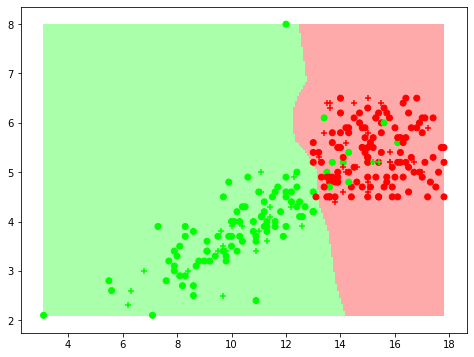

In [64]:
vclf = VotingClassifier(estimators = [ ('lr', clf1), ('lda', clf2), ('qda', clf3), ('lsvc', clf4), ('rsvc', clf5)], 
                       voting='hard')
plot_cat_model(vclf, X, y)

### Baseball Player Data


In [65]:
# Read in the major league players data set

major = pa.read_csv('Data Sets/Major League Height-Weight.csv')   # creates a pandas Dataframe from a .csv file
major = major.rename({'Height(inches)':'Height', 'Weight(pounds)':'Weight'}, axis=1)  
major = major.drop(640, axis=0) 

# Each row of a data frame is a data point - in this case a player.
# Each column is a feature about the data point (its coordinates if you will)

major.head()   # displays the first few rows

,Name,Team,Position,Height,Weight,Age
0,Adam_Donachie,BAL,Catcher,74,180.0,22.99
1,Paul_Bako,BAL,Catcher,74,215.0,34.69
2,Ramon_Hernandez,BAL,Catcher,72,210.0,30.78
3,Kevin_Millar,BAL,First_Baseman,72,210.0,35.43
4,Chris_Gomez,BAL,First_Baseman,73,188.0,35.71


In [66]:
# We are going to make a dictionary of key:value pairs to recode the Position feature to 
# 'Pitcher' and 'Not Pitcher'

pos_dict = {x:1 for x in list(set(major.Position)) if 'Pitcher' in x}
pos_dict2 = {x:0 for x in list(set(major.Position)) if not 'Pitcher' in x}

# Using dictionary comprehensions

pos_dict.update(pos_dict2) # merge the two dictionaries

major_2 = major.copy()   # pandas.dataframe is a mutable object so we use the .copy() command 
                         # otherwise changes to major_2 will change major
    
major_2.Position = major_2.Position.map(pos_dict)  # use the dictionary we made to recode the values with .map()

major_2

,Name,Team,Position,Height,Weight,Age
0,Adam_Donachie,BAL,0,74,180.0,22.99
1,Paul_Bako,BAL,0,74,215.0,34.69
2,Ramon_Hernandez,BAL,0,72,210.0,30.78
3,Kevin_Millar,BAL,0,72,210.0,35.43
4,Chris_Gomez,BAL,0,73,188.0,35.71
...,...,...,...,...,...,...
1029,Brad_Thompson,STL,1,73,190.0,25.08
1030,Tyler_Johnson,STL,1,74,180.0,25.73
1031,Chris_Narveson,STL,1,75,205.0,25.19
1032,Randy_Keisler,STL,1,75,190.0,31.01


In [67]:
X = np.array(major_2[['Height', 'Weight']])
y = np.array(major_2['Position'])

In [68]:
# We define the models that we will combine into an ensemble

clf1 = LogisticRegression(solver='lbfgs')
clf2 = LinearDiscriminantAnalysis()
clf3 = QuadraticDiscriminantAnalysis()
clf4 = SVC(C=1.0, gamma='auto', kernel='linear')
clf5 = SVC(C=1.0, gamma='auto', kernel='rbf')

Training Error: 0.6686819830713422
Testing Error: 0.6796116504854369


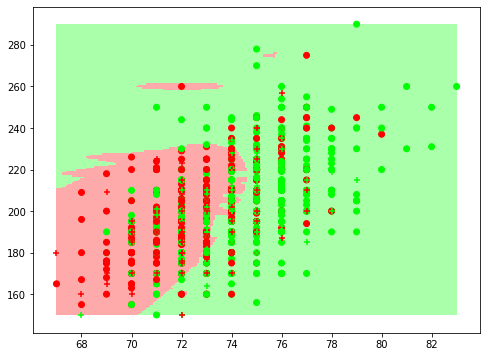

In [90]:
vclf = VotingClassifier(estimators = [ ('lr', clf1), ('lda', clf2), ('qda', clf3), ('lsvc', clf4), ('rsvc', clf5)], 
                       voting='hard', 
                       weights = [1, 1, 1.51, 1, 1.5])
plot_cat_model(vclf, X, y)

One item to do here is to use the *weights* as a tuning parameter and determin the best choice for the classification.